# Model Selection
In this notebook, the model selection capabilities of pyPESTO are demonstrated, which facilitate the selection of the best model from a set of possible models. This includes examples of forward, backward, and brute force methods, as well as criteria such as AIC, AICc, and BIC. Various additional options and convenience methods are also demonstrated.

All specification files use the [PEtab Select](https://github.com/PEtab-dev/petab_select) format, which is a model selection extension to the parameter estimation specification format [PEtab](https://github.com/PEtab-dev/PEtab).

Dependencies can be installed with `pip3 install pypesto[select]`.

## Example Model
This example involves a reaction system with two species (`A` and `B`), with their growth, conversion and decay rates controlled by three parameters ($\theta_1$, $\theta_2$, and $\theta_3$). Many different hypotheses will be considered, which are described in the model specifications file. There, a parameter fixed to zero indicates a hypothesis that the associated reaction(s) should not be in the model.

Synthetic measurement data is used here, which was generated with the "true" model. The comprehensive model includes additional behavior involving a third parameter ($\theta_3$). Hence, during model selection, models with $\theta_3=0$ should be preferred.

![](model_selection_network.jpeg)


## Model Space Specifications File

The model selection specification file can be written in the following compressed format.

| model_subspace_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | 0;estimate  |

Alternatively, models can be explicitly specified. The below table is equivalent to the above table.

| model_subspace_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1_0	| example_modelSelection.yaml	| 0	  | 0   |	0 | 
| M1_1	| example_modelSelection.yaml	| 0	  | 0	| estimate |
| M1_2	| example_modelSelection.yaml	| 0	  | estimate |	0 |
| M1_3	| example_modelSelection.yaml	| estimate |	0	| 0 |
| M1_4	| example_modelSelection.yaml	| 0	  | estimate |	estimate |
| M1_5	| example_modelSelection.yaml	| estimate |	0   |	estimate |
| M1_6	| example_modelSelection.yaml	| estimate |	estimate |	0 |
| M1_7	| example_modelSelection.yaml	| estimate | estimate |	estimate |

Either of the above tables (as [TSV](https://en.wikipedia.org/wiki/Tab-separated_values) files) are valid inputs. Any combinations of cells in the compressed or explicit format is also acceptable, including the following example.

| model_subspace_id | petab_yaml                             | $\theta_1$ | $\theta_2$ | $\theta_3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | 0  |
| M2      | example_modelSelection.yaml | 0;estimate  | 0;estimate  | estimate  |

Due to the topology of the example model, setting $\theta_1$ to zero can result in a model with no dynamics. Hence, for this example, some parameters are set to non-zero fixed values. These parameters are considered as fixed (not estimated) values in criterion (e.g. AIC) calculations.

The model specification table used in this notebook is shown below.

In [1]:
import pandas as pd
from IPython.display import display, HTML


df = pd.read_csv('model_selection/model_space.tsv', sep='\t')
display(HTML(df.to_html(index=False)))

model_subspace_id,petab_yaml,k1,k2,k3
M1_0,example_modelSelection.yaml,0,0,0
M1_1,example_modelSelection.yaml,0.2,0.1,estimate
M1_2,example_modelSelection.yaml,0.2,estimate,0
M1_3,example_modelSelection.yaml,estimate,0.1,0
M1_4,example_modelSelection.yaml,0.2,estimate,estimate
M1_5,example_modelSelection.yaml,estimate,0.1,estimate
M1_6,example_modelSelection.yaml,estimate,estimate,0
M1_7,example_modelSelection.yaml,estimate,estimate,estimate


## Forward Selection, Multiple Searches
Here, we show a typical workflow for model selection. First, a [PEtab Select](https://github.com/petab-dev/petab_select) problem is created, which is used to initialize a pyPESTO model selection problem.

In [2]:
# Helpers for plotting etc.
def get_labels(models):
    labels = {
        model.get_hash(): str(model.model_subspace_id)
        for model in models
    }
    return labels


def get_digraph_labels(models, criterion):
    zero = min(model.get_criterion(criterion) for model in models)
    labels = {
        model.get_hash():
        f'{model.model_subspace_id}\n{model.get_criterion(criterion) - zero:.2f}'
        for model in models
    }
    return labels

# Disable some logged messages that make the model selection log more
# difficult to read.
import tqdm
def nop(it, *a, **k):
    return it
tqdm.tqdm = nop

In [3]:
import pypesto.select
import petab_select
from petab_select import Criterion, Method, ESTIMATE
petab_select_problem = \
    petab_select.Problem.from_yaml('model_selection/petab_select_problem.yaml')

In [4]:
import logging
import pypesto.logging
pypesto.logging.log(level=logging.WARNING, name='pypesto.petab', console=True)
import petab

pypesto_select_problem_1 = \
    pypesto.select.Problem(petab_select_problem=petab_select_problem)

Models can be selected with a model selection algorithm (here: [forward](https://en.wikipedia.org/wiki/Stepwise_regression)) and a comparison criterion (here: [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)). The forward method involves iterations where each iteration tests all models with one additional estimated parameter.

To perform a single iteration, use `select` as shown below. Later in the notebook, `select_to_completion` is demonstrated, which performs multiple consecutive iterations automatically.

As no initial model is specified here, a virtual initial model with no estimated parameters is automatically used to find the "smallest" (in terms of number of estimated parameters) models. In this example, this is the model `M1_0`, which has no estimated parameters.

In [5]:
# Reduce notebook runtime 
minimize_options = {
    'n_starts': 10,
}

best_model_1, _, _ = pypesto_select_problem_1.select(
    method=Method.FORWARD,
    criterion=Criterion.AIC,
    minimize_options=minimize_options,
)

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
virtual_init | M1_0:649bcd9 | AIC          | None         | 3.698e+01    | None         | True        


To search more of the model space, the algorithm can be repeated. As models with no estimated parameters have already been tested, subsequent `select` calls will begin with the next simplest model (in this case, models with exactly 1 estimated parameters, if they exist in the model space), and move on to more complex models.

The best model from the first iteration is supplied as the predecessor (initial) model here.

In [6]:
best_model_2, _, _ = pypesto_select_problem_1.select(
    method=Method.FORWARD,
    criterion=Criterion.AIC,                                                                         
    minimize_options=minimize_options,
    predecessor_model=best_model_1,
)

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
M1_0:649bcd9 | M1_1:9202ace | AIC          | 3.698e+01    | -4.175e+00   | -4.115e+01   | True        
M1_0:649bcd9 | M1_2:c773362 | AIC          | 3.698e+01    | -4.275e+00   | -4.125e+01   | True        
M1_0:649bcd9 | M1_3:e03f5dc | AIC          | 3.698e+01    | -4.705e+00   | -4.168e+01   | True        


Plotting routines are available, to visualize the best model at each iteration of the selection process, or to visualize the graph of models that have been visited in the model space.

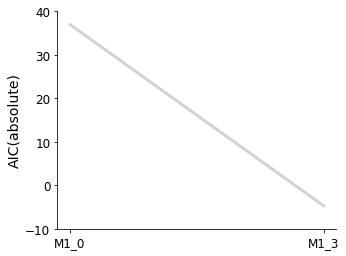

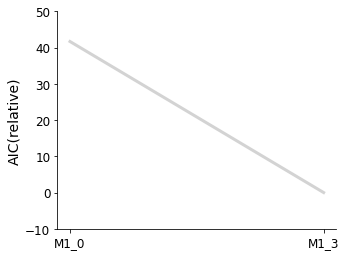

In [7]:
import pypesto.visualize.select as pvs
selected_models = [best_model_1, best_model_2]
ax = pvs.plot_selected_models(
    [best_model_1, best_model_2],
    criterion=Criterion.AIC,
    relative=False,
    labels=get_labels(selected_models),
)
ax = pvs.plot_selected_models(
    [best_model_1, best_model_2],
    criterion=Criterion.AIC,
    labels=get_labels(selected_models),
)
ax.plot();

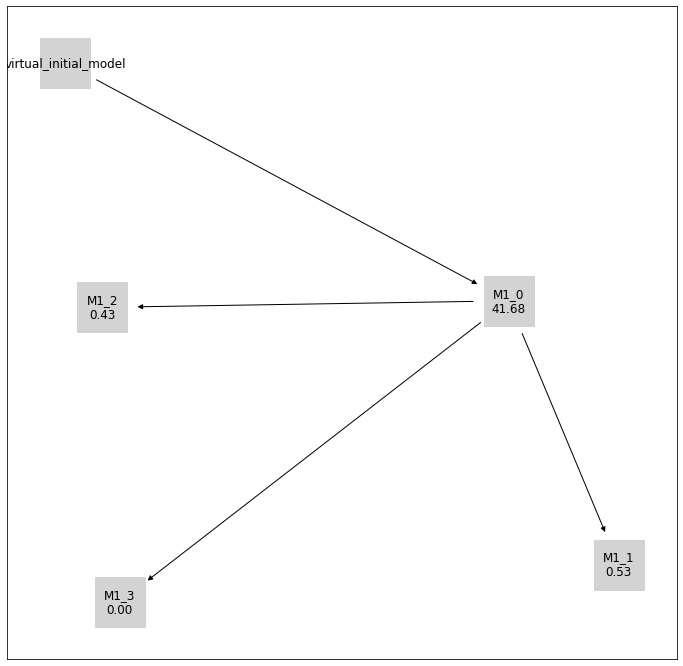

In [8]:
pvs.plot_history_digraph(
    problem=pypesto_select_problem_1,
    labels=get_digraph_labels(
        pypesto_select_problem_1.history.values(),
        criterion=Criterion.AIC,
    ),
);

## Backward Selection, Custom Initial Model
Backward selection is specified by changing the algorithm from `Method.FORWARD` to `Method.BACKWARD`in the `select()` call.

A custom initial model is specified with the optional `predecessor_model` argument of `select()`.

In [9]:
from pprint import pprint
import numpy as np
from petab_select import Model

petab_select_problem.model_space.reset_exclusions()
pypesto_select_problem_2 = \
    pypesto.select.Problem(petab_select_problem=petab_select_problem)

petab_yaml = 'model_selection/example_modelSelection.yaml'
initial_model = Model(
    model_id='myModel',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=0.1,
        k2=ESTIMATE,
        k3=ESTIMATE,
    ),
    criteria={petab_select_problem.criterion: np.inf}
)

print('Initial model:')
print(initial_model)

Initial model:
model_id	petab_yaml	k1	k2	k3
myModel	model_selection/example_modelSelection.yaml	0.1	estimate	estimate


In [10]:
pypesto_select_problem_2.select(
    method=Method.BACKWARD,
    criterion=Criterion.AIC,
    predecessor_model=initial_model,    
    minimize_options=minimize_options,
);

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
:myModel     | M1_1:9202ace | AIC          | inf          | 3.897e+01    | -inf         | True        
:myModel     | M1_2:c773362 | AIC          | inf          | 2.412e+01    | -inf         | True        


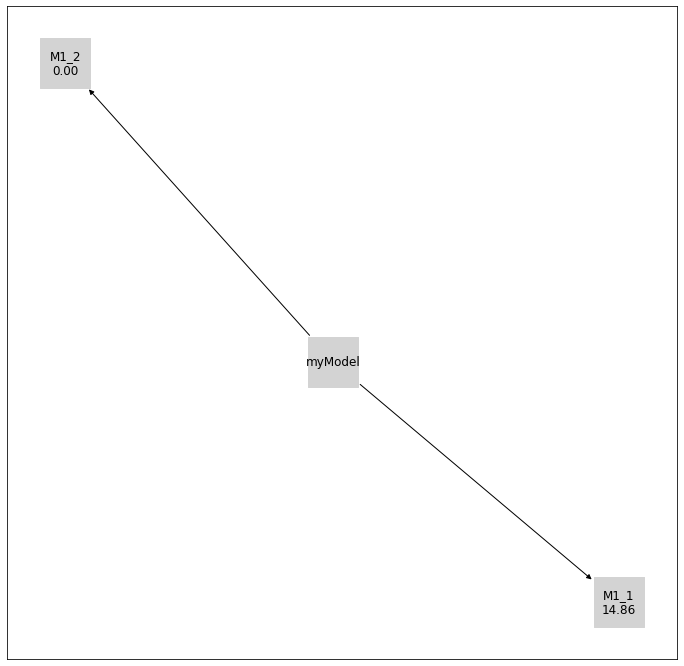

In [11]:
initial_model_label = {
    initial_model.get_hash(): initial_model.model_id
}

pvs.plot_history_digraph(
    problem=pypesto_select_problem_2,
    labels={
        **get_digraph_labels(
            pypesto_select_problem_2.history.values(),
            criterion=Criterion.AIC,
        ),
        **initial_model_label,
    },
);

## Additional Options
There exist additional options that can be used to further customise selection algorithms.

### Select First Improvement
At each selection step, as soon as a model that improves on the previous model is encountered (by the specified criterion), it is selected and immediately used as the previous model in the next iteration of the selection. This is unlike the default behaviour, where all test models at each iteration are optimized, and the best of these is selected.

### Use Previous Maximum Likelihood Estimate as Startpoint
The maximum likelihood estimate parameters from the previous model is used as one of the startpoints in the multistart optimization of the test models. The default behaviour is that all startpoints are automatically generated by pyPESTO.

### Minimize Options
Optimization can be customised with a dictionary that specifies values for the corresponding keyword arguments of [minimize](https://github.com/ICB-DCM/pyPESTO/blob/master/pypesto/optimize/optimize.py).

### Criterion Options
Currently implemented options are: `Criterion.AIC` ([Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)), `Criterion.AICC` ([corrected AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)), and `Criterion.BIC` ([Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion)).

#### Criterion Threshold
A threshold can be specified, such that only models that improve on previous models by the threshold amount in the chosen criterion are accepted.

In [12]:
petab_select_problem.model_space.reset_exclusions()
pypesto_select_problem_3 = \
    pypesto.select.Problem(petab_select_problem=petab_select_problem)
best_models = pypesto_select_problem_3.select_to_completion(
    method=Method.FORWARD,
    criterion=Criterion.BIC,
    select_first_improvement=True,
    startpoint_latest_mle=True,    
    minimize_options=minimize_options,
)

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
virtual_init | M1_0:649bcd9 | BIC          | None         | 3.692e+01    | None         | True        
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
M1_0:649bcd9 | M1_1:9202ace | BIC          | 3.692e+01    | -4.017e+00   | -4.094e+01   | True        
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
M1_1:9202ace | M1_4:3d668e2 | BIC          | -4.017e+00   | -1.683e+00   | 2.334e+00    | False       
M1_1:9202ace | M1_5:d2503eb | BIC          | -4.017e+00   | -2.114e+00   | 1.903e+00    | False       
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | mod

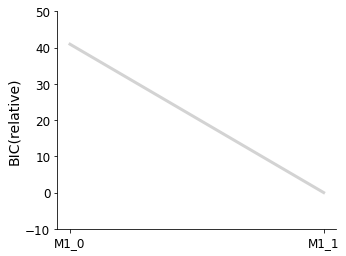

In [13]:
pvs.plot_selected_models(
    selected_models=best_models,
    criterion=Criterion.BIC,
    labels=get_labels(best_models),
);

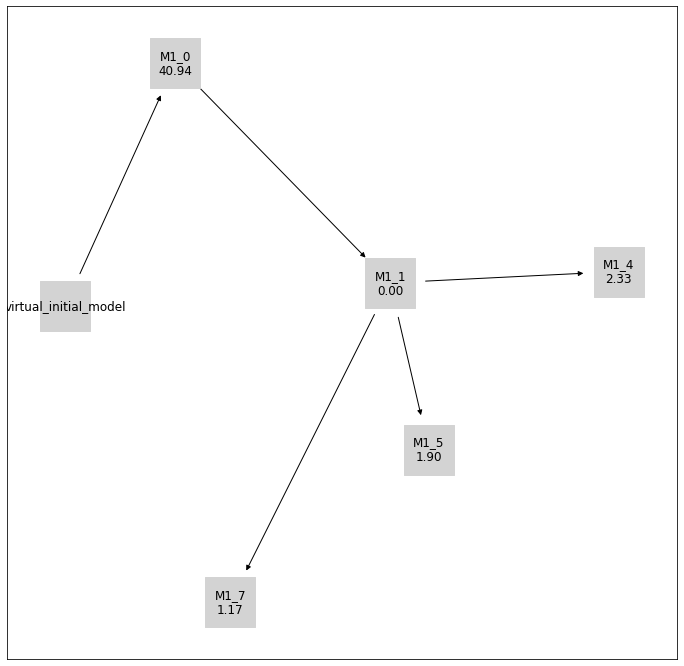

In [14]:
pvs.plot_history_digraph(
    problem=pypesto_select_problem_3,
    criterion=Criterion.BIC,
    relative=False,
    labels=get_digraph_labels(
        pypesto_select_problem_3.history.values(),
        criterion=Criterion.BIC,
    ),
);

In [15]:
# Repeat with AICc and criterion_threshold == 10
petab_select_problem.model_space.reset_exclusions()
pypesto_select_problem_4 = \
    pypesto.select.Problem(petab_select_problem=petab_select_problem)
best_models = pypesto_select_problem_4.select_to_completion(
    method=Method.FORWARD,
    criterion=Criterion.AICC,
    select_first_improvement=True,
    startpoint_latest_mle=True,
    minimize_options=minimize_options,    
    criterion_threshold=10,
)

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
virtual_init | M1_0:649bcd9 | AICc         | None         | 3.778e+01    | None         | True        
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
M1_0:649bcd9 | M1_1:9202ace | AICc         | 3.778e+01    | -1.775e+00   | -3.955e+01   | True        
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
M1_1:9202ace | M1_4:3d668e2 | AICc         | -1.775e+00   | 2.525e+00    | 4.301e+00    | False       
M1_1:9202ace | M1_5:d2503eb | AICc         | -1.775e+00   | 2.095e+00    | 3.870e+00    | False       
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | mod

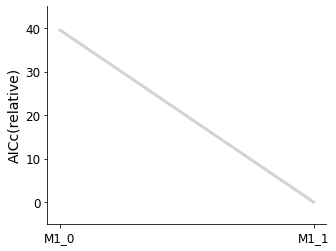

In [16]:
pvs.plot_selected_models(
    selected_models=best_models,
    criterion=Criterion.AICC,
    labels=get_labels(best_models),
);

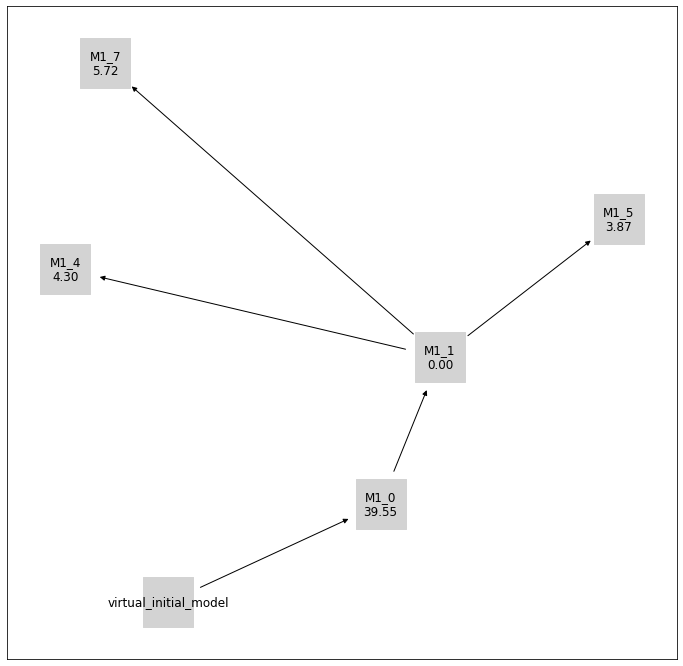

In [17]:
pvs.plot_history_digraph(
    problem=pypesto_select_problem_4,
    criterion=Criterion.AICC,
    relative=False,
    labels=get_digraph_labels(
        pypesto_select_problem_4.history.values(),
        criterion=Criterion.AICC,
    ),
);

## Multistart
Multiple model selections can be run by specifying multiple initial models.

In [18]:
petab_select_problem.model_space.reset_exclusions()
pypesto_select_problem_5 = \
    pypesto.select.Problem(petab_select_problem=petab_select_problem)

initial_model_1 = Model(
    model_id='myModel1',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=0,
        k2=0,
        k3=0,
    ),
    criteria={petab_select_problem.criterion: np.inf},
)

initial_model_2 = Model(
    model_id='myModel2',
    petab_yaml=petab_yaml,
    parameters=dict(
        k1=ESTIMATE,
        k2=ESTIMATE,
        k3=0,
    ),
    criteria={petab_select_problem.criterion: np.inf},
)

initial_models = [initial_model_1, initial_model_2]
best_model, best_models = pypesto_select_problem_5.multistart_select(
    method=Method.FORWARD,
    criterion=Criterion.AIC,
    predecessor_models=initial_models,
    minimize_options=minimize_options,
)

--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
:myModel1    | M1_1:9202ace | AIC          | inf          | 3.897e+01    | -inf         | True        
:myModel1    | M1_2:c773362 | AIC          | inf          | -4.275e+00   | -inf         | True        
:myModel1    | M1_3:e03f5dc | AIC          | inf          | -4.705e+00   | -inf         | True        
--------------------New Selection--------------------
model0       | model        | crit         | model0_crit  | model_crit   | crit_diff    | accept      
:myModel2    | M1_7:afa580e | AIC          | inf          | 1.934e+01    | -inf         | True        


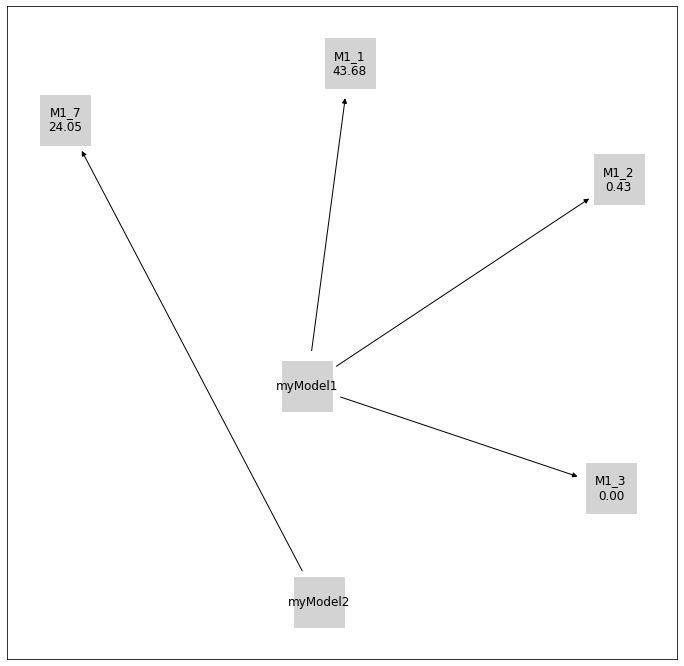

In [19]:
initial_model_labels = {
    initial_model.get_hash(): initial_model.model_id
    for initial_model in initial_models
}

pvs.plot_history_digraph(
    problem=pypesto_select_problem_5,
    criterion=Criterion.AIC,
    relative=False,
    labels={
        **get_digraph_labels(
            pypesto_select_problem_5.history.values(),
            criterion=Criterion.AIC,
        ),
        **initial_model_labels,
    },
);